In [1]:
import numpy as np
import gsd.hoomd

# ---------- Minimum-image utilities ----------
def mic_displacement_ortho(r, r0, L):
    """Minimum-image displacement for orthorhombic boxes.
    r, r0: (N,3) positions; L: (3,) box lengths"""
    dr = r - r0
    L = np.asarray(L)[None, :]
    dr -= L * np.round(dr / L)
    return dr

def msd_from_dr(dr):
    return np.mean(np.sum(dr**2, axis=1))

def Fs_from_dr(dr, k, tiny=1e-18):
    r = np.linalg.norm(dr, axis=1)
    k = np.atleast_1d(k)                 # ensure 1-D
    out = np.empty(k.shape[0], dtype=float)

    for i, kval in enumerate(k):
        kr = kval * r
        vals = np.ones_like(kr)
        nz = np.abs(kr) >= tiny
        vals[nz] = np.sin(kr[nz]) / kr[nz]
        out[i] = vals.mean()
    return out 

def gsd_time_info(path,dt):
    with gsd.hoomd.open(path, mode='r') as traj:
        T = len(traj)
        steps = np.array([traj[i].configuration.step for i in range(T)], dtype=np.int64)

    return (steps - steps[0]) * dt

# ---------- Analysis over a HOOMD v5 GSD trajectory ----------
def analyze_gsd_mic(gsd_path, ks, dt=0.001, stride=1, ref_frame=0, assume_orthorhombic=True):
    ks = np.atleast_1d(ks)

    with gsd.hoomd.open(gsd_path, 'r') as traj:
        f0 = traj[ref_frame]
        r0 = f0.particles.position.astype(np.float64)
        step0 = f0.configuration.step
        box = f0.configuration.box  # [Lx, Ly, Lz, xy, xz, yz]
        L = np.array(box[:3], dtype=np.float64)

        times = []
        msd_vals = []
        fs_vals = []

        for t in range(ref_frame, len(traj), stride):
            fr = traj[t]
            r = fr.particles.position.astype(np.float64)

            if assume_orthorhombic and np.allclose(box[3:], 0.0):
                dr = mic_displacement_ortho(r, r0, L)
            else:
                raise RuntimeError("Triclinic MIC requires freud or images; set assume_orthorhombic=True")

            # compute relative time
            rel_time = (fr.configuration.step - step0) * dt

            # store values
            times.append(rel_time)
            msd_vals.append(msd_from_dr(dr))
            fs_vals.append(Fs_from_dr(dr, ks))

    # Convert to numpy arrays
    times = np.array(times)                  # shape (T,)
    msd_arr = np.column_stack((times, msd_vals))  # shape (T, 2)

    fs_arr = np.array(fs_vals).T  # shape (K, T)
    # add times along last dimension
    fs_with_time = np.stack([np.tile(times, (len(ks), 1)), fs_arr], axis=2)  # shape (K, T, 2)

    return msd_arr, fs_with_time


In [7]:
test = gsd.hoomd.open("/home/chengling/Research/Project/vitrimer/data/test/vitrimerPaper/NVT/GPU/rho0.8/traj_T0.00100000_rho0.800000_dt0.001_wait20000000.gsd", 'r')

In [11]:
test[1].configuration.step-test[0].configuration.step

np.uint64(12)

In [4]:
# Choose ks (e.g., around first peak of S(k); if unsure, try a small grid)
ks = np.linspace(2.0, 7.0, 1)

msd_t, Fskt = analyze_gsd_mic(
    "/home/chengling/Research/Project/vitrimer/data/test/rho0.923333/traj_T0.00100000_rho0.923333_wait0.gsd",
    ks=ks,
    stride=1,            # sample every 10 frames
    ref_frame=0,          # displacements relative to frame 0
    assume_orthorhombic=True  # set False + install freud for triclinic MIC
)



FileNotFoundError: [Errno 2] No such file or directory: '/home/chengling/Research/Project/vitrimer/data/test/rho0.923333/traj_T0.00100000_rho0.923333_wait0.gsd'

In [53]:
np.linspace(2.0, 7.0, 1)

array([2.])

/tmp/ipykernel_1476801/1300888111.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(Fskt[0,:,0]),Fskt[0,:,1])


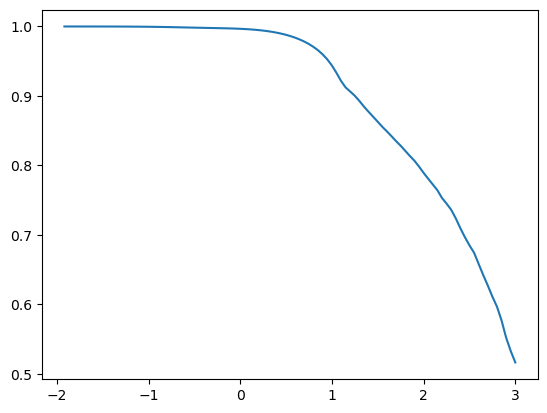

In [57]:
import matplotlib.pyplot as plt
plt.plot(np.log10(Fskt[0,:,0]),Fskt[0,:,1])

plt.show()

/tmp/ipykernel_1476801/2740865029.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(Fskt[5,:,0]),Fskt[5,:,1])


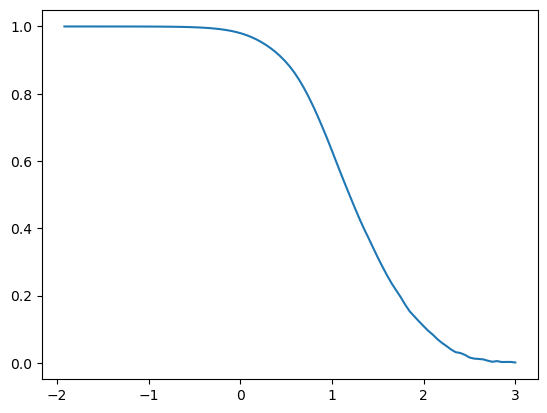

In [39]:
import matplotlib.pyplot as plt
plt.plot(np.log10(Fskt[5,:,0]),Fskt[5,:,1])

plt.show()

In [2]:
from pathlib import Path
import os

def analyze_and_save_one(
    read_dir,
    ks,
    out_dir,
    *,
    rho, T, wait, index,
    dt=0.001,
    stride=1,
    ref_frame=0,
    assume_orthorhombic=True,
    ftol=6   # precision for rho/T in filename
):
    """
    Analyze one trajectory and save:
      - msd_rho{rho}_T{T}_wait{wait}_idx{index}.csv   (time,MSD)
      - Fs_rho{rho}_T{T}_wait{wait}_idx{index}_k{k}.csv  (time,Fs)
    CSVs contain only time,value.
    """
    rho_tag  = f"{rho:.{6}f}"
    T_tag    = f"{T:.{8}f}"
    wait_tag = str(int(wait))
    idx_tag  = str(int(index))

    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    ks = np.atleast_1d(ks).astype(float)
    read_dir = Path(read_dir)
    traj_path = read_dir / f"traj_T{T_tag}_rho{rho_tag}_dt0.001_wait{wait_tag}.gsd"
    if not os.path.exists(traj_path):
        print(str(traj_path) + " does not exist")
        return
    # --- compute ---
    msd_arr, fs_with_time = analyze_gsd_mic(
        str(traj_path),
        ks=ks,
        dt=dt,
        stride=stride,
        ref_frame=ref_frame,
        assume_orthorhombic=assume_orthorhombic
    )


    # --- save MSD ---
    # msd_csv = out_dir / f"msd_rho{rho_tag}_T{T_tag}_wait{wait_tag}_idx{idx_tag}.csv"
    msd_csv = out_dir / f"msd_T{T_tag}_rho{rho_tag}_wait{wait_tag}.csv"
    np.savetxt(msd_csv, msd_arr, delimiter=",", header="time,MSD", comments="")
    print(f"Saved {msd_csv}")

    # --- save Fs for each k ---
    for i, k in enumerate(ks):
        fs_arr = fs_with_time[i]  # (T,2)
        # fs_csv = out_dir / f"Fs_rho{rho_tag}_T{T_tag}_wait{wait_tag}_idx{idx_tag}_k{k}.csv"
        fs_csv = out_dir / f"Fs_T{T_tag}_rho{rho_tag}_wait{wait_tag}_k{k}.csv"
        np.savetxt(fs_csv, fs_arr, delimiter=",", header="time,Fs", comments="")
        print(f"Saved {fs_csv}")

In [7]:
np.linspace(7.0, 8.0, 2)

array([7., 8.])

In [3]:
ks = [6.0]
wait_lists = np.linspace(0, 1000000, 11)
# for rho in [0.8, 1.0]:
#     for kT in [0.1, 0.05, 0.02, 0.01, 0.005, 0.002]:
#         for wait in wait_lists:
#             analyze_and_save_one(
#             f"/home/chengling/Research/Project/vitrimer/data/test/vitrimerPaper/NVT/GPU/rho{rho:.{1}f}", ks, out_dir=f"/home/chengling/Research/Project/vitrimer/data/test/vitrimerPaper/NVT/GPU/rho{rho:.{1}f}/dynamics",
#             rho=rho, T=kT, wait=wait, index=0,
#             dt=0.001, stride=1, ref_frame=0, assume_orthorhombic=True
#         )
for rho in [0.92333]:
    # for kT in [1.0, 0.1, 0.03, 0.01, 0.003, 0.001]:
    for kT in [1.0, 0.1, 0.03]:
        for wait in wait_lists:
            analyze_and_save_one(
            f"/home/chengling/Research/Project/vitrimer/data/test/vitrimerPaper/NVT/V5Langevin/rho{rho:.{5}f}", ks, out_dir=f"/home/chengling/Research/Project/vitrimer/data/test/vitrimerPaper/NVT/V5Langevin/rho{rho:.{5}f}/dynamics",
            rho=rho, T=kT, wait=wait, index=0,
            dt=0.001, stride=1, ref_frame=0, assume_orthorhombic=True
        )

Saved /home/chengling/Research/Project/vitrimer/data/test/vitrimerPaper/NVT/V5Langevin/rho0.92333/dynamics/msd_T1.00000000_rho0.923330_wait0.csv
Saved /home/chengling/Research/Project/vitrimer/data/test/vitrimerPaper/NVT/V5Langevin/rho0.92333/dynamics/Fs_T1.00000000_rho0.923330_wait0_k6.0.csv
Saved /home/chengling/Research/Project/vitrimer/data/test/vitrimerPaper/NVT/V5Langevin/rho0.92333/dynamics/msd_T1.00000000_rho0.923330_wait100000.csv
Saved /home/chengling/Research/Project/vitrimer/data/test/vitrimerPaper/NVT/V5Langevin/rho0.92333/dynamics/Fs_T1.00000000_rho0.923330_wait100000_k6.0.csv
Saved /home/chengling/Research/Project/vitrimer/data/test/vitrimerPaper/NVT/V5Langevin/rho0.92333/dynamics/msd_T1.00000000_rho0.923330_wait200000.csv
Saved /home/chengling/Research/Project/vitrimer/data/test/vitrimerPaper/NVT/V5Langevin/rho0.92333/dynamics/Fs_T1.00000000_rho0.923330_wait200000_k6.0.csv
Saved /home/chengling/Research/Project/vitrimer/data/test/vitrimerPaper/NVT/V5Langevin/rho0.92333/